# Deep Ambient Occlusion using GANs

The goal of this work is to take **input rendered images** representing **per-pixel position** and **per-pixel normals**, and **output an image** that represents **per-pixel ambient occlusion**.

We will use a **GAN** structure (that contains a **discriminator** network and a **generator** network).

The code here is based on **DeepIllumination** (Thomas and Forbes 2018). However, they were using this approach for learning *global illumination*, not *ambient occlusion*. 

![DeepIllumination](deep.jpg)


I didn't have access to their training data, so I adapted their code to work with an ambient occlusion dataset from **Deep Shading** (Nalbach et al. 2017).

Source code for DeepIllumination: https://github.com/CreativeCodingLab/DeepIllumination

Datasets from Deep Shading: http://deep-shading-datasets.mpi-inf.mpg.de/

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

I have a set of data on my local computer -- a collection of **images** in **different directories** with **matching filenames**.

In [2]:
dataset_root = '../../Conference'
print(os.listdir(dataset_root))
for subdir in ["Normals", "Position", "GroundTruth"]:
    subdirpath = os.path.join(dataset_root, subdir)
    print("Items in", subdirpath, ":")
    print(os.listdir(subdirpath)[:10])

['GroundTruth', 'Normals', 'Position']
Items in ../../Conference\Normals :
['0000000001.exr', '0000000001_flip_h.exr', '0000000001_flip_v.exr', '0000000001_rot_180.exr', '0000000001_rot_270.exr', '0000000001_rot_90.exr', '0000000002.exr', '0000000002_flip_h.exr', '0000000002_flip_v.exr', '0000000002_rot_180.exr']
Items in ../../Conference\Position :
['0000000001.exr', '0000000001_flip_h.exr', '0000000001_flip_v.exr', '0000000001_rot_180.exr', '0000000001_rot_270.exr', '0000000001_rot_90.exr', '0000000002.exr', '0000000002_flip_h.exr', '0000000002_flip_v.exr', '0000000002_rot_180.exr']
Items in ../../Conference\GroundTruth :
['0000000001.exr', '0000000001_flip_h.exr', '0000000001_flip_v.exr', '0000000001_rot_180.exr', '0000000001_rot_270.exr', '0000000001_rot_90.exr', '0000000002.exr', '0000000002_flip_h.exr', '0000000002_flip_v.exr', '0000000002_rot_180.exr']


(**.exr** files are just a file format for high-dynamic range (HDR) images. OpenCV can load them just like PNG, JPG, etc.)

Here we create a custom `Dataset` for loading in our data. All we need is to define is:

- `__len__` (returns how many items are in the dataset)

- `__getitem__(index)`, which returns the set of paired data representing that particular item in the dataset.

In [3]:
# convert from NumPy arrays to PyTorch tensors
# and normalize between [-1,+1]
def load_image(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_NEAREST)
    image = np.transpose(image, (2, 0, 1))
    image = torch.from_numpy(image)
    image = torch.FloatTensor(image.size()).copy_(image)
    image = image.mul_(2).add_(-1)
    return image

class DataLoaderHelper(torch.utils.data.Dataset):
    def __init__(self, image_dir):
        super(DataLoaderHelper, self).__init__()
        self.normal_path = os.path.join(image_dir, "Normals")
        self.position_path = os.path.join(image_dir, "Position")
        self.gt_path = os.path.join(image_dir, "GroundTruth")
        self.image_filenames = [x for x in os.listdir(self.gt_path)]
    
    def __getitem__(self, index):
        normal = load_image(os.path.join(self.normal_path, self.image_filenames[index]))
        position = load_image(os.path.join(self.position_path, self.image_filenames[index]))
        gt = load_image(os.path.join(self.gt_path, self.image_filenames[index]))
        
        return normal, position, gt
    
    def __len__(self):
        return len(self.image_filenames)

In [4]:
data_loader_helper = DataLoaderHelper(dataset_root)

Sample from our data-loader, to get a set of input and output images:

In [5]:
example_normal, example_position, example_gt = data_loader_helper[0]

In [6]:
print(example_normal.size())
print(example_position.size())
print(example_gt.size())

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


min/max of image is tensor(-0.9927) to tensor(0.9990)
dimensions:  torch.Size([3, 256, 256])


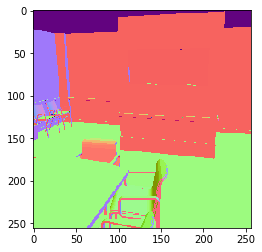

min/max of image is tensor(-0.8013) to tensor(0.4824)
dimensions:  torch.Size([3, 256, 256])


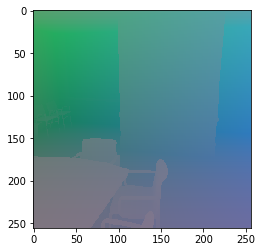

min/max of image is tensor(-0.4902) to tensor(1.)
dimensions:  torch.Size([3, 256, 256])


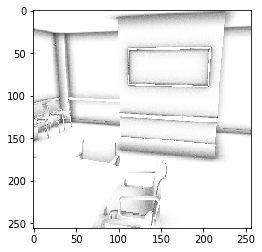

In [7]:
plt.ioff()

def inspect(image):
    image = image.numpy()
    image = (image + 1.0) / 2.0
    if len(image.shape) < 3:
        image = np.expand_dims(image, axis=2)
    if image.shape[0] == 1:
        image = np.repeat(image, 3, axis=0)
    #image = image.clip(0, 1)
    image = np.transpose(image, (1, 2, 0))
    return image

def display(image):
    print("min/max of image is", torch.min(image), "to", torch.max(image))
    print("dimensions: ", image.size())
    plt.imshow(inspect(image))
    plt.show()
    
display(example_normal)
display(example_position)
display(example_gt)

## Defining the Generator Network

The Generator network **G** is a U-Net. It uses a series of convolutions and deconvolutions with skip-connections.

![U-Net](unet.jpg)


In [11]:
class G(nn.Module):
    def __init__(self, n_channel_input, n_channel_output, n_filters):
        super(G, self).__init__()
        self.conv1 = nn.Conv2d(n_channel_input, n_filters, 4, 2, 1)
        self.conv2 = nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1)
        self.conv3 = nn.Conv2d(n_filters * 2, n_filters * 4, 4, 2, 1)
        self.conv4 = nn.Conv2d(n_filters * 4, n_filters * 8, 4, 2, 1)
        self.conv5 = nn.Conv2d(n_filters * 8, n_filters * 8, 4, 2, 1)
        self.conv6 = nn.Conv2d(n_filters * 8, n_filters * 8, 4, 2, 1)
        self.conv7 = nn.Conv2d(n_filters * 8, n_filters * 8, 4, 2, 1)
        self.conv8 = nn.Conv2d(n_filters * 8, n_filters * 8, 4, 2, 1)

        self.deconv1 = nn.ConvTranspose2d(n_filters * 8, n_filters * 8, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(n_filters * 8 * 2, n_filters * 8, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(n_filters * 8 * 2, n_filters * 8, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(n_filters * 8 * 2, n_filters * 8, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(n_filters * 8 * 2, n_filters * 4, 4, 2, 1)
        self.deconv6 = nn.ConvTranspose2d(n_filters * 4 * 2, n_filters * 2, 4, 2, 1)
        self.deconv7 = nn.ConvTranspose2d(n_filters * 2 * 2, n_filters, 4, 2, 1)
        self.deconv8 = nn.ConvTranspose2d(n_filters * 2, n_channel_output, 4, 2, 1)

        self.batch_norm = nn.BatchNorm2d(n_filters)
        self.batch_norm2 = nn.BatchNorm2d(n_filters * 2)
        self.batch_norm4 = nn.BatchNorm2d(n_filters * 4)
        self.batch_norm8 = nn.BatchNorm2d(n_filters * 8)

        self.leaky_relu = nn.LeakyReLU(0.2, True)
        self.relu = nn.ReLU(True)

        self.dropout = nn.Dropout(0.5)

        self.tanh = nn.Tanh()
        
        
    def forward(self, input):
        encoder1 = self.conv1(input)
        encoder2 = self.batch_norm2(self.conv2(self.leaky_relu(encoder1)))
        encoder3 = self.batch_norm4(self.conv3(self.leaky_relu(encoder2)))
        encoder4 = self.batch_norm8(self.conv4(self.leaky_relu(encoder3)))
        encoder5 = self.batch_norm8(self.conv5(self.leaky_relu(encoder4)))
        encoder6 = self.batch_norm8(self.conv6(self.leaky_relu(encoder5)))
        encoder7 = self.batch_norm8(self.conv7(self.leaky_relu(encoder6)))
        encoder8 = self.conv8(self.leaky_relu(encoder7))

        decoder1 = self.dropout(self.batch_norm8(self.deconv1(self.relu(encoder8))))
        decoder1 = torch.cat((decoder1, encoder7), 1)
        decoder2 = self.dropout(self.batch_norm8(self.deconv2(self.relu(decoder1))))
        decoder2 = torch.cat((decoder2, encoder6), 1)
        decoder3 = self.dropout(self.batch_norm8(self.deconv3(self.relu(decoder2))))
        decoder3 = torch.cat((decoder3, encoder5), 1)
        decoder4 = self.batch_norm8(self.deconv4(self.relu(decoder3)))
        decoder4 = torch.cat((decoder4, encoder4), 1)
        decoder5 = self.batch_norm4(self.deconv5(self.relu(decoder4)))
        decoder5 = torch.cat((decoder5, encoder3), 1)
        decoder6 = self.batch_norm2(self.deconv6(self.relu(decoder5)))
        decoder6 = torch.cat((decoder6, encoder2),1)
        decoder7 = self.batch_norm(self.deconv7(self.relu(decoder6)))
        decoder7 = torch.cat((decoder7, encoder1), 1)
        decoder8 = self.deconv8(self.relu(decoder7))
        output = self.tanh(decoder8)
        return output

## Defining the Discriminator Network

The Discriminator **D** is a simpler design. It just uses a set of convolutions with ReLU's and batch-norms to progressively downsample.

![Discriminator](discriminator.jpg)

In [12]:
class D(nn.Module):
    def __init__(self, n_channel_input, n_channel_output, n_filters):
        super(D, self).__init__()
        self.conv1 = nn.Conv2d(n_channel_input + n_channel_output, n_filters, 4, 2, 1)
        self.conv2 = nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1)
        self.conv3 = nn.Conv2d(n_filters * 2, n_filters * 4, 4, 2, 1)
        self.conv4 = nn.Conv2d(n_filters * 4, n_filters * 8, 4, 1, 1)
        self.conv5 = nn.Conv2d(n_filters * 8, 1, 4, 1, 1)

        self.batch_norm2 = nn.BatchNorm2d(n_filters * 2)
        self.batch_norm4 = nn.BatchNorm2d(n_filters * 4)
        self.batch_norm8 = nn.BatchNorm2d(n_filters * 8)

        self.leaky_relu = nn.LeakyReLU(0.2, True)

        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        encoder1 = self.conv1(input)
        encoder2 = self.batch_norm2(self.conv2(self.leaky_relu(encoder1)))
        encoder3 = self.batch_norm4(self.conv3(self.leaky_relu(encoder2)))
        encoder4 = self.batch_norm8(self.conv4(self.leaky_relu(encoder3)))
        encoder5 = self.conv5(self.leaky_relu(encoder4))
        output =  self.sigmoid(encoder5)
        return output

The authors also had some custom code to let them manually set the initial weights of the network, rather than just randomizing it with whatever PyTorch does by default:

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

We'll use a batch size of 16. Using this `DataLoader`, when we load the input images, it'll actually be a stack of 16 all in the same Tensor.

So, the Tensor is a 4D matrix of size:

**Batch Size** x **Num Channels** x **Height** x **Width**

In [14]:
batch_size = 16
train_data = torch.utils.data.DataLoader(dataset=data_loader_helper, 
                                         num_workers=0, 
                                         batch_size=batch_size, 
                                         shuffle=True)

Defining the generator and discriminator networks here (including that custom weight initialization):

In [15]:
n_channel_input = example_normal.size()[0] + example_position.size()[0]      # 3 channels for normals, 3 channels for position
n_channel_output = example_gt.size()[0]     # 1 channel for output AO image
n_filters = 128
netG = G(n_channel_input, n_channel_output, n_filters)
netG.apply(weights_init)
netD = D(n_channel_input, n_channel_output, n_filters)
netD.apply(weights_init)
print(netG)
print(netD)

G(
  (conv1): Conv2d(6, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv8): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), paddin

We'll define some empty GPU Tensors to hold each batch of incoming data. This isn't necessary but can improve performance:

In [16]:
normal = torch.FloatTensor(batch_size, example_normal.size()[0], 256, 256)
position = torch.FloatTensor(batch_size, example_position.size()[0], 256, 256)
gt = torch.FloatTensor(batch_size, example_gt.size()[0], 256, 256)

Define our loss functions. We'll use **Binary Cross-Entropy loss** in our discriminator, and **L1 loss** in our generator.

In [17]:
criterion = nn.BCELoss() # Binary Cross-Entropy Loss between target and output
criterion_l1 = nn.L1Loss() # L1 per-pixel loss

l1_lambda = 100

Define the learning rate and an optimizer for each network. **Adam** is a common solver. Basically, it helps to adapt the learning rate during training.

In [18]:
lr = 0.0002

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

Now we'll move all the relevant data from the CPU to the GPU.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("moving all data to", device)

netD = netD.to(device)
netG = netG.to(device)
criterion = criterion.to(device)
criterion_l1 = criterion_l1.to(device)

normal = normal.to(device)
position = position.to(device)
gt = gt.to(device)

moving all data to cuda:0


Here's the loop that does the training. I'll go through it in detail:

<IPython.core.display.Javascript object>


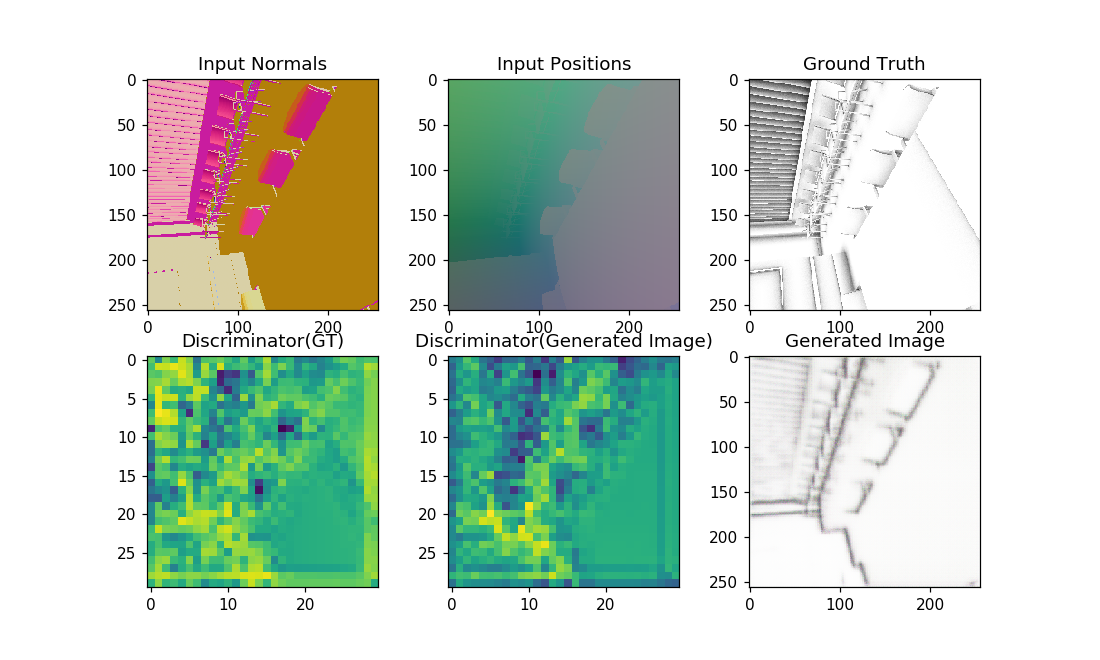

In [20]:
%matplotlib notebook
f, axarr = plt.subplots(2,3)
fig = plt.gcf()
fig.set_size_inches(10, 6)
fig.show()

def train(num_iterations):
    plt.ion()
    
    for (i, images) in enumerate(train_data):
        
        # ==========================================================================================
        # get the batched input and GT data
        
        (normal_cpu, position_cpu, gt_cpu) = (images[0], images[1], images[2])
        normal.data.copy_(normal_cpu)
        position.data.copy_(position_cpu)
        gt.data.copy_(gt_cpu)
        
        # ==========================================================================================
        # update the generator network
        
        # zero out the gradients in the networks
        netD.zero_grad()
        
        # discriminator output with GT image -- should return all 1's
        output_d_real = netD(torch.cat((normal, position, gt), 1))
        
        # compute the loss between D(real) and all 1's
        err_d_real = criterion(output_d_real, torch.ones_like(output_d_real))
        
        # use the generator to synthesize an image from our inputs
        fake_B = netG(torch.cat((normal, position), 1))
        
        # discriminator output with FAKE image -- should return all 0's
        
        # NOTE: we do fake_B.detach() so gradients don't pass all the way 
        # up to the generator network here
        output_d_fake = netD(torch.cat((normal, position, fake_B.detach()), 1))
        
        # compute the loss between D(fake) and all 0's
        err_d_fake = criterion(output_d_fake, torch.zeros_like(output_d_fake))
        
        err_d = (err_d_real + err_d_fake) * 0.5
        
        # compute gradients for discriminator
        err_d.backward()
        
        # backprop and update the weights of the discriminator network
        optimizerD.step()
        
        # ==========================================================================================
        
        # now, update the generator network
        
        netG.zero_grad()
        
        # NOTE: we are not detaching fake_B here because we want to backprop
        # into the generator's weights
        output_d = netD(torch.cat((normal, position, fake_B), 1))
        
        err_g = criterion(output_d, torch.ones_like(output_d)) + l1_lambda * criterion_l1(fake_B, gt)
        
        # compute gradients for generator
        err_g.backward()
        
        # backprop and update the weights of the generator network
        optimizerG.step()
        
        # ==========================================================================================
        # plot images
        normal_img = inspect(normal_cpu[0])
        position_img = inspect(position_cpu[0])
        gt_img = inspect(gt[0].detach().cpu())
        d_real_img = output_d_real[0][0].detach().cpu().numpy()
        d_fake_img = output_d_fake[0][0].detach().cpu().numpy()
        fake_B_img = inspect(fake_B[0].detach().cpu())
        
        axarr[0,0].clear()
        axarr[0,0].title.set_text('Input Normals')
        axarr[0,0].imshow(normal_img)
        
        axarr[0,1].clear()
        axarr[0,1].title.set_text('Input Positions')
        axarr[0,1].imshow(position_img)
        
        axarr[0,2].clear()
        axarr[0,2].title.set_text('Ground Truth')
        axarr[0,2].imshow(gt_img)
        
        axarr[1,0].clear()
        axarr[1,0].title.set_text('Discriminator(GT)')
        axarr[1,0].imshow(d_real_img)
        
        axarr[1,1].clear()
        axarr[1,1].title.set_text('Discriminator(Generated Image)')
        axarr[1,1].imshow(d_fake_img)
        
        axarr[1,2].clear()
        axarr[1,2].title.set_text('Generated Image')
        axarr[1,2].imshow(fake_B_img)
        
        fig.canvas.draw()
        # ==========================================================================================
        
        if i > num_iterations:
            print("breaking")
            break
    plt.ioff()

In [21]:
train(1) # just train for one iteration so we can visualize the output

breaking


In [22]:
train(100) # train for lots of iterations

breaking


In [ ]:
train(1000) # train for lots of iterations

And that's it! I hope you're inspired to use deep learning. Have fun!